In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import math
import cv2

In [2]:
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from sklearn.utils import shuffle

In [3]:
path = 'C:/dataset'

In [4]:
categories = ['train', 'test', 'val', 'auto_test'] # 전처리된 데이터셋을 훈련용, 평가용, 검증용으로 구분
data_dir = path+'/osteoarthritis/'
# device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu') # Mac OS
device = torch.device( 'cuda' if torch.cuda.is_available() else 'cpu' )

In [5]:
# 이미지 전처리 함수들
def resize_image(img, size=(128, 128)):
    return cv2.resize(img, size)

def clahe_image(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(img)

def normalize_img(img):
    return cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

def denoise_img(img):
    return cv2.fastNlMeansDenoising(img, None, 30, 7, 21)

def adjust_gamma(image, gamma=0.5):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(image, table)

def crop_knee(image, crop_height, crop_width):
    h, w = image.shape[:2]
    center = (h // 2, w // 2)
    cropped_img = image[
        center[0] - crop_height // 2 : center[0] + crop_height // 2,
        center[1] - crop_width // 2 : center[1] + crop_width // 2
    ]
    return cropped_img

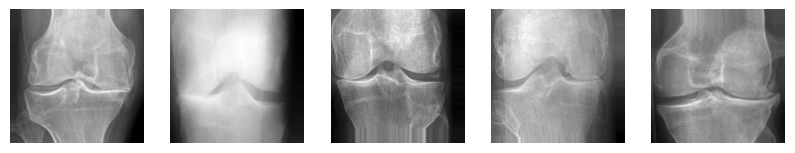

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import numpy as np
import os
import cv2
import random
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

# Data augmentation settings
datagen = ImageDataGenerator(
    rotation_range=5, 
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

def adjust_gamma(image, gamma=1.0):
    inv_gamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** inv_gamma * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

def augment_images(data_dir, label, augment_count=700, gamma=0.5):
    label_path = os.path.join(data_dir, str(label))
    augmented_dir = os.path.join(label_path, 'augmented')
    os.makedirs(augmented_dir, exist_ok=True)

    img_names = os.listdir(label_path)
    img_names = [name for name in img_names if os.path.isfile(os.path.join(label_path, name))]
    
    if not img_names:
        print(f"No images found in directory {label_path}")
        return np.array([])

    generated_count = 0
    while generated_count < augment_count:
        img_name = np.random.choice(img_names)
        img_path = os.path.join(label_path, img_name)
        try:
            img = load_img(img_path, color_mode='grayscale', target_size=(224, 224))
            img = img_to_array(img).astype('uint8')
            img = np.squeeze(img, axis=-1)
            img = adjust_gamma(img, gamma=gamma)
            img = np.expand_dims(img, axis=-1)
            img = np.expand_dims(img, axis=0)

            for batch in datagen.flow(img, batch_size=1, save_to_dir=augmented_dir, save_prefix='aug', save_format='png'):
                generated_count += 1
                break
        except PermissionError:
            print(f"Permission denied: Unable to access file {img_path}")
        except Exception as e:
            print(f"Error processing file {img_path}: {e}")

    augmented_images = []
    for img_name in os.listdir(augmented_dir):
        img_path = os.path.join(augmented_dir, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            augmented_images.append(img)
    
    return np.array(augmented_images)

images = augment_images(data_dir, 4)

if images.size > 0:
    random_images = images[np.random.choice(images.shape[0], 5, replace=False)]

    plt.figure(figsize=(10, 5))
    for i, img in enumerate(random_images):
        plt.subplot(1, 5, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.show()
else:
    print("No images found.")


In [7]:
# Data augmentation settings
datagen = ImageDataGenerator(
    rotation_range=5,  # Increased for more variety
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

def augment_images(data_dir, label, augment_count=600):
    label_path = os.path.join(data_dir, 'train', str(label))
    augmented_dir = os.path.join(label_path, 'augmented')
    os.makedirs(augmented_dir, exist_ok=True)

    img_names = os.listdir(label_path)
    img_names = [name for name in img_names if os.path.isfile(os.path.join(label_path, name))]
    generated_count = 0

    while generated_count < augment_count:
        img_name = np.random.choice(img_names)
        img_path = os.path.join(label_path, img_name)
        try:
            img = load_img(img_path, color_mode='grayscale', target_size=(224, 224))
            img = img_to_array(img)
            img = img.reshape((1,) + img.shape)

            for batch in datagen.flow(img, batch_size=1, save_to_dir=augmented_dir, save_prefix='aug', save_format='png'):
                generated_count += 1
                break  # 한 장만 생성하고 반복문 탈출
        except PermissionError:
            print(f"Permission denied: Unable to access file {img_path}")
        except Exception as e:
            print(f"Error processing file {img_path}: {e}")

# # Augment images in label 4
data_dir = path+'/osteoarthritis/train/'  # 적절한 데이터 디렉토리로 변경
augment_images(data_dir, 4)

# Display augmented images
augmented_img_paths = os.listdir(os.path.join(data_dir, 'train', '4', 'augmented'))
augmented_img_paths = shuffle(augmented_img_paths)[:6]  # 무작위로 6개 선택

for i, img_name in enumerate(augmented_img_paths):
    img_path = os.path.join(data_dir, 'train', '4', 'augmented', img_name)
    img = load_img(img_path, color_mode='grayscale', target_size=(128, 128))
    plt.imshow(img, cmap='gray')
    plt.title(f'Augmented Image {i + 1}')
    plt.show()

ValueError: 'a' cannot be empty unless no samples are taken